# nuScenes CAN bus tutorial
This page describes how to use the nuScenes CAN bus expansion data.
The CAN bus is a vehicle bus over which information such as position, velocity, acceleration, steering, lights, battery and many more are submitted.
We recommend you start by reading the [README](https://github.com/nutonomy/nuscenes-devkit/tree/master/python-sdk/nuscenes/can_bus/README.md).

## Setup
To install the can bus expansion, please download the files from https://www.nuscenes.org/download and copy the files into your nuScenes can folder, e.g. `/data/sets/nuscenes/can_bus`. You will also need to update your `nuscenes-devkit`.

## Initialization
To initialize the can bus API, run the following:

In [2]:
from nuscenes.can_bus.can_bus_api import NuScenesCanBus
nusc_can = NuScenesCanBus(dataroot='/datasets/nuscenes')

# Overview
Let us get an overview of all the CAN bus messages and some basic statistics (min, max, mean, stdev, etc.). We will pick an arbitrary scene for that.

In [3]:
scene_name = 'scene-0001'
nusc_can.print_all_message_stats(scene_name)

{
  "ms_imu": [
    "ms_imu",
    "pose",
    "steeranglefeedback",
    "vehicle_monitor",
    "zoe_veh_info",
    "zoesensors"
  ],
  "pose": [
    "ms_imu",
    "pose",
    "steeranglefeedback",
    "vehicle_monitor",
    "zoe_veh_info",
    "zoesensors"
  ],
  "steeranglefeedback": [
    "ms_imu",
    "pose",
    "steeranglefeedback",
    "vehicle_monitor",
    "zoe_veh_info",
    "zoesensors"
  ],
  "vehicle_monitor": [
    "ms_imu",
    "pose",
    "steeranglefeedback",
    "vehicle_monitor",
    "zoe_veh_info",
    "zoesensors"
  ],
  "zoesensors": [
    "ms_imu",
    "pose",
    "steeranglefeedback",
    "vehicle_monitor",
    "zoe_veh_info",
    "zoesensors"
  ],
  "zoe_veh_info": [
    "ms_imu",
    "pose",
    "steeranglefeedback",
    "vehicle_monitor",
    "zoe_veh_info",
    "zoesensors"
  ]
}


## Visualization
Next we plot the values in a CAN bus message over time. 

As an example let us pick the steering angle feedback message and the key called "value" as described in the [README](https://github.com/nutonomy/nuscenes-devkit/tree/master/python-sdk/nuscenes/can_bus/README.md). The plot below shows the steering angle. It seems like the scene starts with a strong left turn and then continues more or less straight.

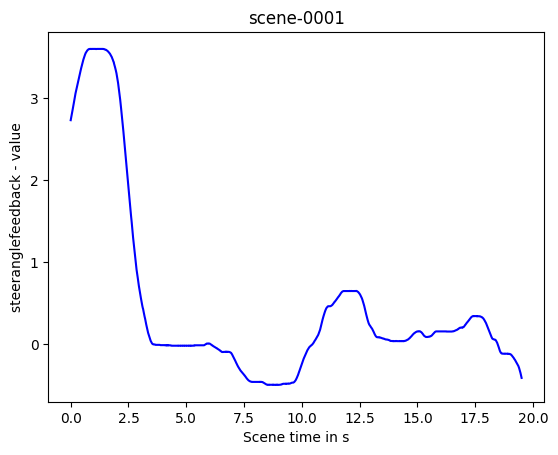

In [4]:
message_name = 'steeranglefeedback'
key_name = 'value'
nusc_can.plot_message_data(scene_name, message_name, key_name)

If the data we want to plot is multi-dimensional, we need to provide an additional argument to select the dimension. Here we plot the acceleration along the lateral dimension (y-axis). We can see that initially this acceleration is higher.

In [8]:
nusc_can.get_messages(scene_name, 'steeranglefeedback')

[{'utime': 1531883530450069, 'value': 2.7331856086231183},
 {'utime': 1531883530459229, 'value': 2.7454029133870756},
 {'utime': 1531883530469572, 'value': 2.7628562059070187},
 {'utime': 1531883530479096, 'value': 2.7785641691749694},
 {'utime': 1531883530489334, 'value': 2.79427213244292},
 {'utime': 1531883530499958, 'value': 2.8099800957108707},
 {'utime': 1531883530509560, 'value': 2.825688058978821},
 {'utime': 1531883530520057, 'value': 2.8413960222467636},
 {'utime': 1531883530530050, 'value': 2.8553586562627213},
 {'utime': 1531883530539609, 'value': 2.8693212902786795},
 {'utime': 1531883530549927, 'value': 2.8850292535466218},
 {'utime': 1531883530559443, 'value': 2.9024825460665653},
 {'utime': 1531883530569197, 'value': 2.918190509334516},
 {'utime': 1531883530579751, 'value': 2.933898472602466},
 {'utime': 1531883530589756, 'value': 2.949606435870417},
 {'utime': 1531883530600026, 'value': 2.9670597283903604},
 {'utime': 1531883530609613, 'value': 2.9845130209103035},
 {'

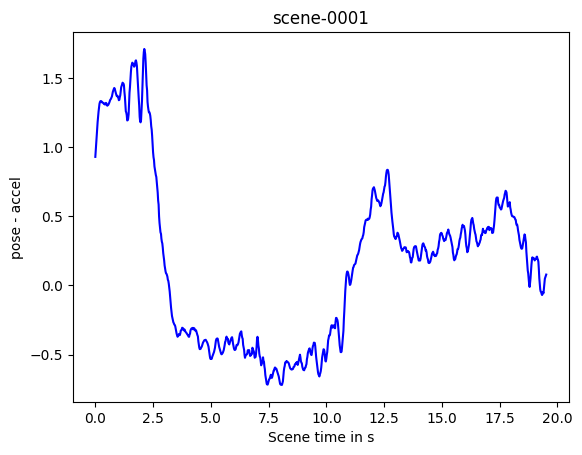

In [5]:
message_name = 'pose'
key_name = 'accel'
nusc_can.plot_message_data(scene_name, message_name, key_name, dimension=1)

We can also retrieve the raw data and compare the wheel speeds to the vehicle speeds. Here we convert the wheel speed from rounds per minute to m/s and the vehicle speed from km/h to m/s. We can see that there is a small offset between the speeds.

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Retrieve raw data.
wheel_speed = nusc_can.get_messages(scene_name, 'zoe_veh_info')
wheel_speed = np.array([(m['utime'], m['FL_wheel_speed']) for m in wheel_speed])

veh_speed = nusc_can.get_messages(scene_name, 'vehicle_monitor')
veh_speed = np.array([(m['utime'], m['vehicle_speed']) for m in veh_speed])

# Convert to m/s.
radius = 0.305  # Known Zoe wheel radius in meters.
circumference = 2 * np.pi * radius
wheel_speed[:, 1] *= circumference / 60
veh_speed[:, 1] *= 1 / 3.6

# Normalize time.
wheel_speed[:, 0] = (wheel_speed[:, 0] - wheel_speed[0, 0]) / 1e6
veh_speed[:, 0] = (veh_speed[:, 0] - veh_speed[0, 0]) / 1e6

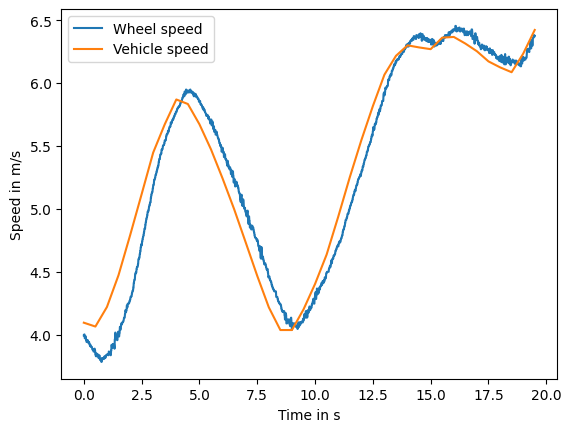

In [7]:
plt.plot(wheel_speed[:, 0], wheel_speed[:, 1])
plt.plot(veh_speed[:, 0], veh_speed[:, 1])
plt.xlabel('Time in s')
plt.ylabel('Speed in m/s')
plt.legend(['Wheel speed', 'Vehicle speed']);

Now let us render the baseline route for this scene. The blue line below shows the baseline route extended by 50m beyond the start and end of the scene. The orange line indicates the ego vehicle pose. To differentiate the start and end point we highlight the start with a red cross. We can see that there is a slight deviation of the actual poses from the route.

In [ ]:
nusc_can.plot_baseline_route(scene_name)

## Error handling
Please note that some scenes are not well aligned with the baseline route. This can be due to diversions or because the human driver was not following a route. We compute all misaligned routes by checking if each ego pose has a baseline route within 5m.

In [ ]:
print(nusc_can.list_misaligned_routes())

Furthermore a small number of scenes have no CAN bus data at all. These can therefore not be used.

In [ ]:
print(nusc_can.can_blacklist)